<a href="https://colab.research.google.com/github/ramkamal2000/cs6910_assignment3/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Required Libraries

In [2]:
!pip install wandb

# Import Libraries

In [3]:
import pickle
import pandas as pd
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
import difflib
import wandb
import seaborn as sns

from nltk import edit_distance
from collections import Counter
import itertools

In [4]:
# MAKE APPROPRIATE CHANGES

root_dir = '/content/drive/MyDrive/Colab Notebooks/DL3'
# root_dir = os.getcwd()

# Download Dataset

In [5]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir(root_dir+'/dakshina_dataset_v1.0'):
  tarfile.open(root_dir+"/dakshina_dataset_v1.0.tar").extractall()

File ‘dakshina_dataset_v1.0.tar’ already there; not retrieving.



In [60]:
# logging into wandb
wandb.login(key='14394907543f59ea21931529e34b4d80d2ca8c9c')
wandb.init(project='rnn_analysis')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


_runtime,6
_timestamp,1621348546
_step,1


_runtime,▁█
_timestamp,▁█
_step,▁█


# Load Dataset

In [61]:
# class to help load data
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["ta"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['output', 'input', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv(root_dir + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv(root_dir + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv(root_dir + '/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

      # shuffling the dataset i.e. rows of the dataset
      lex[div] = lex[div].sample(frac=1, random_state=6910)
      lex[div] = lex[div].reset_index(drop=True)

    lex['test'] = lex['test'].sample(frac=1, random_state=6910)
    lex['test'].drop(labels=['count'], axis=1, inplace=True)
    lex['test'] = lex['test'].reset_index(drop=True)
    return lex

  @staticmethod
  def _generate_batch(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):
            
            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, data_dict['max_target_length']),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')

            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        # decoder input sequence
                        # does not include the <EOW> token
                        decoder_input_data[i, t] = word 
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the <SOW> token
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

  @staticmethod
  def _generate_batch_greedy(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):

            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, 1),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')
            
            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t==0 :
                        decoder_input_data[i, t] = 1 # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [62]:
# tokenizer class
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<SOW>'
    self.stop_token = '<EOW>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}
    self.decode_dict_output.update({2:''})

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list =np.array([self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word])
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = np.array([self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]])
        output_list.append(integer_list)
      
      return output_list
    
  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '') for integer in integers[:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [63]:
# wrapper module that encapsulates all earlier classes and functions
def return_data_dict(languages=["ta"], batch_size=32):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  data_dict['in_size'] = len(tk.input_corpus) + 1
  data_dict['out_size'] = len(tk.output_corpus) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')


  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()


  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test


  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))


  data_dict['max_source_length'] = max(data_dict['train']['max_source_length'], data_dict['val']['max_source_length'], data_dict['test']['max_source_length'])
  data_dict['max_target_length'] = max(data_dict['train']['max_target_length'], data_dict['val']['max_target_length'], data_dict['test']['max_target_length'])


  data_dict['train']['batch'] = data_loader._generate_batch(X_train, Y_train, data_dict, data_dict['out_size'], batch_size)
  data_dict['train']['batch_greedy'] = data_loader._generate_batch_greedy(X_train, Y_train, data_dict, data_dict['out_size'], batch_size)
  
  data_dict['val']['batch'] = data_loader._generate_batch(X_val, Y_val, data_dict, data_dict['out_size'], batch_size)
  data_dict['val']['batch_greedy'] = data_loader._generate_batch_greedy(X_val, Y_val, data_dict, data_dict['out_size'], batch_size)

  data_dict['test']['batch'] = data_loader._generate_batch(X_test, Y_test, data_dict, data_dict['out_size'], batch_size)  
  data_dict['test']['batch_greedy'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict, data_dict['out_size'], batch_size)    
  data_dict['test']['batch_1'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict, data_dict['out_size'], 1)

  data_dict['tokenizer'] = tk

  return data_dict

In [64]:
# we just need the tokenizer for this notebook
data_dict = return_data_dict()
tk = data_dict['tokenizer']
input_vocab = tk.input_corpus[3:]
len(input_vocab)

26

# RNN w/o Attention Dataset Loading

In [65]:
# loading rnn+beam
path_rnn_beam = root_dir+'/rnn/rnn_beam.csv'
df_rnn_beam = pd.read_csv(path_rnn_beam)
X = df_rnn_beam.X.to_list()
Y_true = df_rnn_beam.Y_pred.to_list()
Y_pred = df_rnn_beam.Y_true.to_list()
match = [1*(a==b) for a,b in zip(Y_true, Y_pred)]

In [66]:
# rnn+beam accuracy
sum(match)/len(match)

0.32415501165501165

In [67]:
# loading rnn+greedy
path_rnn_greedy = root_dir+'/rnn/rnn_greedy.csv'
df_rnn_greedy = pd.read_csv(path_rnn_greedy)
X = df_rnn_greedy.X.to_list()
Y_true = df_rnn_greedy.Y_true.to_list()
Y_pred = df_rnn_greedy.Y_pred.to_list()
match = [1*(a==b) for a,b in zip(Y_true, Y_pred)]

In [68]:
# rnn+greedy accuracy
sum(match)/len(match)

0.4726107226107226

In [69]:
df = pd.DataFrame({
    'X' : X,
    'true' : Y_true,
    'pred' : Y_pred,
    'match' : match
})

In [70]:
df.head()

,X,true,pred,match
0,youri,யூரி,யூரி,1
1,preim,பிரேம்,பிராம்,0
2,elimaiyaaka,எளிமையாக,எளிமையாக,1
3,kwantam,குவாண்டம்,குவண்டம்,0
4,yavvithamaana,எவ்விதமான,எவ்விதமான,1


## Length Of English Input

In [71]:
df_2 = df.copy()
df_2['X_len'] = df_2.apply(lambda x: len(x['X']), axis=1)

df_2 = df_2.groupby(['X_len', 'match']).count()
df_2.reset_index(level='match', inplace=True)
df_2.drop(columns=['true', 'pred'], inplace=True)

df_3 = df_2.groupby(level='X_len').sum()
df_3.drop(columns=['match'], inplace=True)
df_3 = df_3.rename(columns={'X': 'total'})

df_2 = df_2.rename(columns={'X': 'count'})

df_4 = pd.concat([df_2, df_3], axis=1)
df_4.reset_index(level='X_len', inplace=True)

len_values = df_4.X_len.unique()
full_dict = df_4.set_index(['X_len', 'match']).to_dict()
count_dict, total_dict = full_dict['count'], full_dict['total']

In [72]:
acc_values = [count_dict.get((len, 1), 0)/total_dict.get((len, 1), 1) for len in len_values] 

In [73]:
plt.bar(len_values, acc_values)
plt.grid()
plt.xlabel('Input Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input Length')

wandb.log({'Accuracy vs Input Length': plt})

## Edit Distance

In [74]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)

df_3 = df_2[df_2['match']==0]
df_3.drop(columns=['match'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
df_3.edit.plot.hist()
plt.grid()
plt.xlabel('Edit Distance')
plt.title('Error F vs ED')

wandb.log({'Error Frequency vs Edit Distance': plt})

# Tamil Alphabet Wise Accuracy Rate

In [76]:
diff_list = []

for y_true, y_pred in zip(Y_true, Y_pred):
  output_list = [li for li in difflib.ndiff(y_true, y_pred) if li[0] != ' ']
  diff_list += output_list

In [77]:
plus_list, minus_list = [], []

for diff in diff_list:
  if diff[0]=='+':
    plus_list.append(diff[2:])
  else:
    minus_list.append(diff[2:])

net_list = plus_list + minus_list

In [78]:
master_input = []
master_output = []

for word in Y_true:
  master_input += list(word)

for word in Y_pred:
  master_output += list(word)

In [79]:
plus_counter = Counter(plus_list)
minus_counter = Counter(minus_list)
net_counter = Counter(net_list)

master_input_counter = Counter(master_input)
master_output_counter = Counter(master_output)

In [80]:
for key in minus_counter.keys():
  # print(key, minus_counter[key], master_counter[key])
  minus_counter[key] = minus_counter[key] / master_input_counter[key]

for key in plus_counter.keys():
  # print(key, plus_counter[key], master_counter[key])
  plus_counter[key] = plus_counter[key] / master_output_counter[key]

In [81]:
# top 10 - fraction of letters omitted that are mistakes
df_minus = pd.DataFrame(minus_counter.most_common(10), columns=['Char', 'Omit Fraction'])
print(df_minus.head())

wandb.log({'Character Missing Fraction': wandb.Table(columns=['Char', 'Omit Fraction'],
                                                     data=df_minus)})

  Char  Omit Fraction
0    ௌ       1.000000
1    ஃ       1.000000
2    ஐ       0.800000
3    ஓ       0.789474
4    ஷ       0.750000


In [82]:
# top 10 - fraction of letters outputted that are mistakes
df_plus = pd.DataFrame(plus_counter.most_common(10), columns=['Char', 'Excess Fraction'])
print(df_plus.head())

wandb.log({'Character Excess Fraction': wandb.Table(columns=['Char', 'Excess Fraction'],
                                                    data=df_plus)})

  Char  Excess Fraction
0    ஐ         0.900000
1    ஓ         0.692308
2    ஈ         0.583333
3    ஷ         0.370370
4    ஸ         0.321839


# "Confusion Matrix"

In [83]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)
df_2['mod_dif'] = df_2.apply(lambda z: abs(len(z['true']) - len(z['pred'])), axis=1)

df_3 = df_2[df_2['edit']==1]
df_3 = df_3[df_3['mod_dif']==0]
df_3.drop(columns=['match', 'edit', 'mod_dif'], inplace=True)

Y1_true = df_3.true.to_list()
Y1_pred = df_3.pred.to_list()

In [84]:
diff_list = []

for y_true, y_pred in zip(Y1_true, Y1_pred):
  output_list = tuple([li for li in difflib.ndiff(y_true, y_pred) if li[0] != ' '])
  if(len(output_list)==2):
    diff_list.append(output_list)

In [85]:
hm = np.zeros((len(tk.output_corpus), len(tk.output_corpus)))

for true, pred in diff_list:
  hm[tk.encode_dict_output[true[-1]]-1][tk.encode_dict_output[pred[-1]]-1] += 1

In [86]:
df_hm = pd.DataFrame(hm)
df_hm.columns = list(range(1, len(tk.output_corpus)+1))
df_hm.index = list(range(1, len(tk.output_corpus)+1))
df_hm.index.name, df_hm.columns.name = 'True', 'Pred'

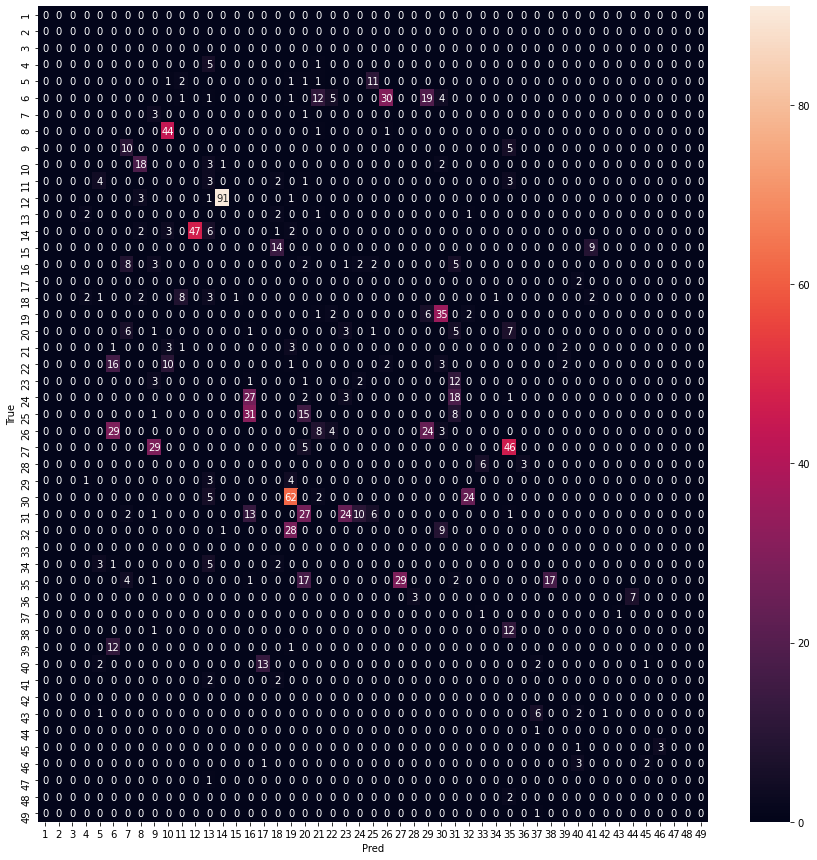

In [87]:
plt.figure(figsize=(15, 15))
fig = sns.heatmap(df_hm, annot=True, fmt='g')

wandb.log({'Confusion Matrix For ED=1': wandb.Image(fig, caption='Confusion Matrix For ED=1')})
plt.show()

In [88]:
one_diff_counter = Counter(diff_list)
one_diff_counter = [(a, b, c) for (a, b), c in one_diff_counter.most_common(20)]
df_ofc = pd.DataFrame(one_diff_counter)
print(df_ofc.head())

wandb.log({"ED=1 Top Mistranliterations": wandb.Table(columns=['Original', 'Output', 'Count'],
                                                      data=df_ofc)})

     0    1   2
0  - ற  + ர  91
1  - ள  + ல  62
2  - ர  + ற  47
3  - ூ  + ோ  46
4  - ட  + த  44


## Random Samples

In [89]:
df_2 = df.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)

df_2_wrong = df_2[df_2['match']==0]
df_2_wrong = df_2_wrong.groupby('edit').nth(0)
df_2_wrong.reset_index(inplace=True)

In [90]:
print(df_2_wrong.head())

wandb.log({"Random Samples": wandb.Table(dataframe=df_2_wrong)})

   edit          X       true       pred  match
0     1      preim     பிரேம்     பிராம்      0
1     2    puudaan     பூடான்   பூட்டான்      0
2     3  nayathodu   நயத்தோடு    நாயதோடு      0
3     4  ahmedabad  அகமதாபாத்  அகாடிபாட்      0
4     5  vicarikka     வழக்கு   விகரிக்க      0


# Attention Dataset Loading

In [91]:
path_attn_beam = root_dir+'/attention/beam_attn'
Y_true, Y_pred = pd.read_pickle(path_attn_beam)
match = [1*(y_true==y_pred) for y_true, y_pred in zip(Y_true, Y_pred)]

In [92]:
sum(match)/len(match)

0.5366603248938973

In [93]:
path_attn_greedy = root_dir+'/attention/attn_greedy.csv'
df_attn_greedy = pd.read_csv(path_attn_greedy)
X = df_attn_greedy.X.to_list()
Y_true = df_attn_greedy.Y_pred.to_list()
Y_pred = df_attn_greedy.Y_true.to_list()
match = [1*(a==b) for a,b in zip(Y_true, Y_pred)]

In [94]:
sum(match)/len(match)

0.518502331002331

In [95]:
dfa = pd.DataFrame({
    'X' : X,
    'true' : Y_true,
    'pred' : Y_pred,
    'match' : match
})

# What Has Attention Done Correctly

In [97]:
wandb.init(project='attn_analysis')

In [98]:
# examples where vanilla worked, but attention failed

df_2 = df[df['match']==1].drop(columns=['match', 'pred'])
df_3 = dfa[dfa['match']==0].drop(columns=['match', 'true'])
df_4 = pd.merge(df_2, df_3, how='inner', on=['X'])
print(df_4.head())

wandb.log({'Failure of Attention':
           wandb.Table(dataframe=df_4)})

                 X          true          pred
0      elimaiyaaka      எளிமையாக      எளிமையாக
1    yavvithamaana     எவ்விதமான     எவ்விதமான
2  thoontriyathaal   தோன்றியதால்   தோன்றியதால்
3    pozhudupoakku  பொழுதுபோக்கு  பொழுதுபோக்கு
4          aayeena          ஆயின          ஆயின


In [99]:
# examples where attention worked, but vanilla failed

df_2 = df[df['match']==0].drop(columns=['match', 'true'])
df_3 = dfa[dfa['match']==1].drop(columns=['match', 'pred'])
df_4 = pd.merge(df_2, df_3, how='inner', on=['X'])
print(df_4.head())

wandb.log({'Failure of Vanilla':
           wandb.Table(dataframe=df_4)})

             X       pred       true
0      kooldan    கூல்டன்    கோல்டன்
1      puudaan   பூட்டான்     பூடான்
2        bakaa       பாகா        பகா
3  seerudaikal  சீருதைகள்  சீருடைகள்
4      aayinar     ஆய்னர்     ஆயினர்


# Edit Distance Analysis

In [100]:
df_c = df_4.copy()
df_c['edit'] = df_c.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)

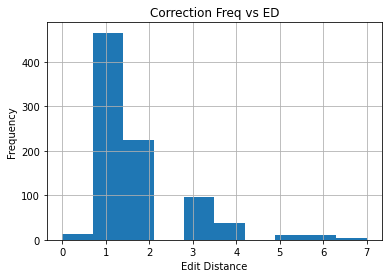

In [101]:
df_c.edit.plot.hist()
plt.grid()
plt.xlabel("Edit Distance")
plt.title("Correction Freq vs ED")

wandb.log({"Correction Freq vs ED":
           wandb.Image(plt, caption="Correction Freq vs ED")})

# "Correction Confusion Matrix"

In [102]:
df_2 = df_c.copy()
df_2['edit'] = df_2.apply(lambda x: edit_distance(x['true'], x['pred']), axis=1)
df_2['mod_dif'] = df_2.apply(lambda z: abs(len(z['true']) - len(z['pred'])), axis=1)

df_3 = df_2[df_2['edit']==1]
df_3 = df_3[df_3['mod_dif']==0]
df_3.drop(columns=['edit', 'mod_dif'], inplace=True)

Y1_true = df_3.true.to_list()
Y1_pred = df_3.pred.to_list()

In [103]:
diff_list = []

for y_true, y_pred in zip(Y1_true, Y1_pred):
  output_list = tuple([li for li in difflib.ndiff(y_true, y_pred) if li[0] != ' '])
  if(len(output_list)==2):
    diff_list.append(output_list)

In [104]:
hm = np.zeros((len(tk.output_corpus), len(tk.output_corpus)))

for true, pred in diff_list:
  hm[tk.encode_dict_output[true[-1]]-1][tk.encode_dict_output[pred[-1]]-1] += 1

In [105]:
df_hm = pd.DataFrame(hm)
df_hm.columns = list(range(1, len(tk.output_corpus)+1))
df_hm.index = list(range(1, len(tk.output_corpus)+1))
df_hm.index.name, df_hm.columns.name = 'True', 'Pred'

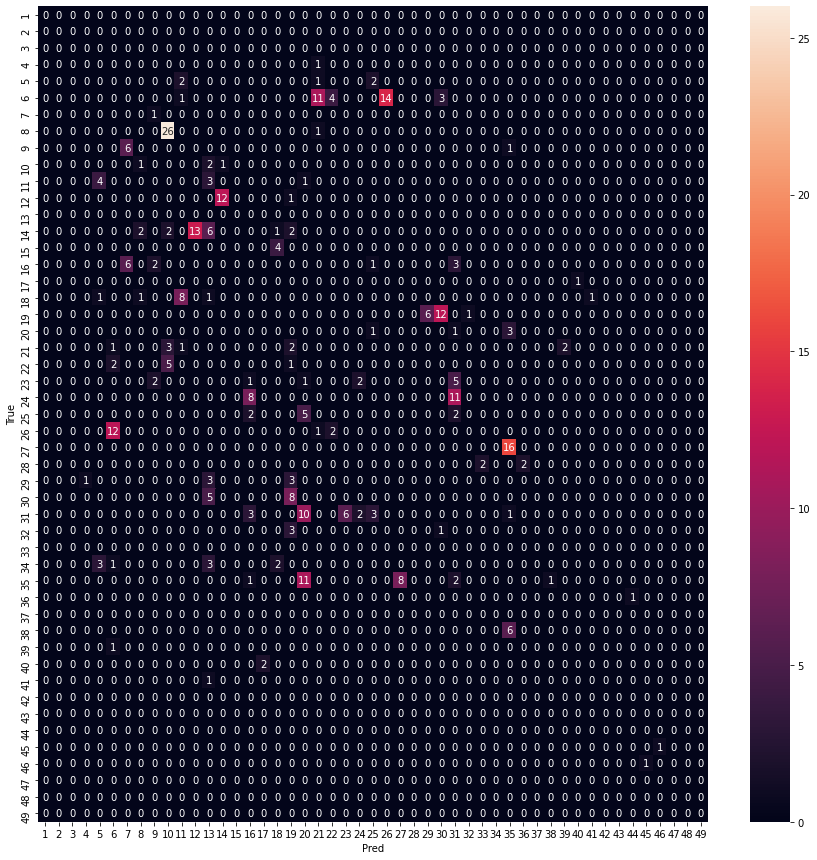

In [106]:
plt.figure(figsize=(15, 15))
fig = sns.heatmap(df_hm, annot=True, fmt='g')

wandb.log({'Correction Confusion Matrix For ED=1': wandb.Image(fig, caption='Correction Confusion Matrix For ED=1')})
plt.show()

In [107]:
one_diff_counter = Counter(diff_list)
one_diff_counter = [(a, b, c) for (a, b), c in one_diff_counter.most_common(20)]
df_ofc = pd.DataFrame(one_diff_counter)
print(df_ofc.head())

wandb.log({"ED=1 Top Corrected Mistranliterations": wandb.Table(columns=['Original', 'Output', 'Count'],
                                                                data=df_ofc)})

     0    1   2
0  - ட  + த  26
1  - ூ  + ோ  16
2  - ன  + ண  14
3  - ர  + ற  13
4  - ண  + ன  12


# Attention Heatmap

In [108]:
wandb.init(project='heatmap_analysis')

_runtime,17
_timestamp,1621350557
_step,4


_runtime,▁▂▃▅█
_timestamp,▁▂▃▅█
_step,▁▃▅▆█


In [109]:
path_attn_weights = root_dir+'/attention/attn_weights'
all_attn_weights = pd.read_pickle(path_attn_weights)

df_2 = dfa.copy()
df_2['idx'] = df_2.index
df_2['X_len'] = df_2.apply(lambda x: len(x['X']), axis=1)
df_3 = df_2.groupby('X_len').nth(1).reset_index(level=0)

In [110]:
len_list = range(4, 22, 2)

df_4 = df_3[df_3['X_len'].isin(len_list)].reset_index(drop=True)
print(df_4.head())

   X_len             X        true        pred  match  idx
0      4          gita         கிட        கீதை      0   78
1      6        betles     பெட்லஸ்  பீட்டில்ஸ்      0   37
2      8      kaaliyaa      காலியா      காலியா      1    7
3     10    vikkiraman  விக்கிரமன்  விக்கிரமன்      1   32
4     12  mikkavaraaga   மிக்கவராக   மிக்கவராக      1   24


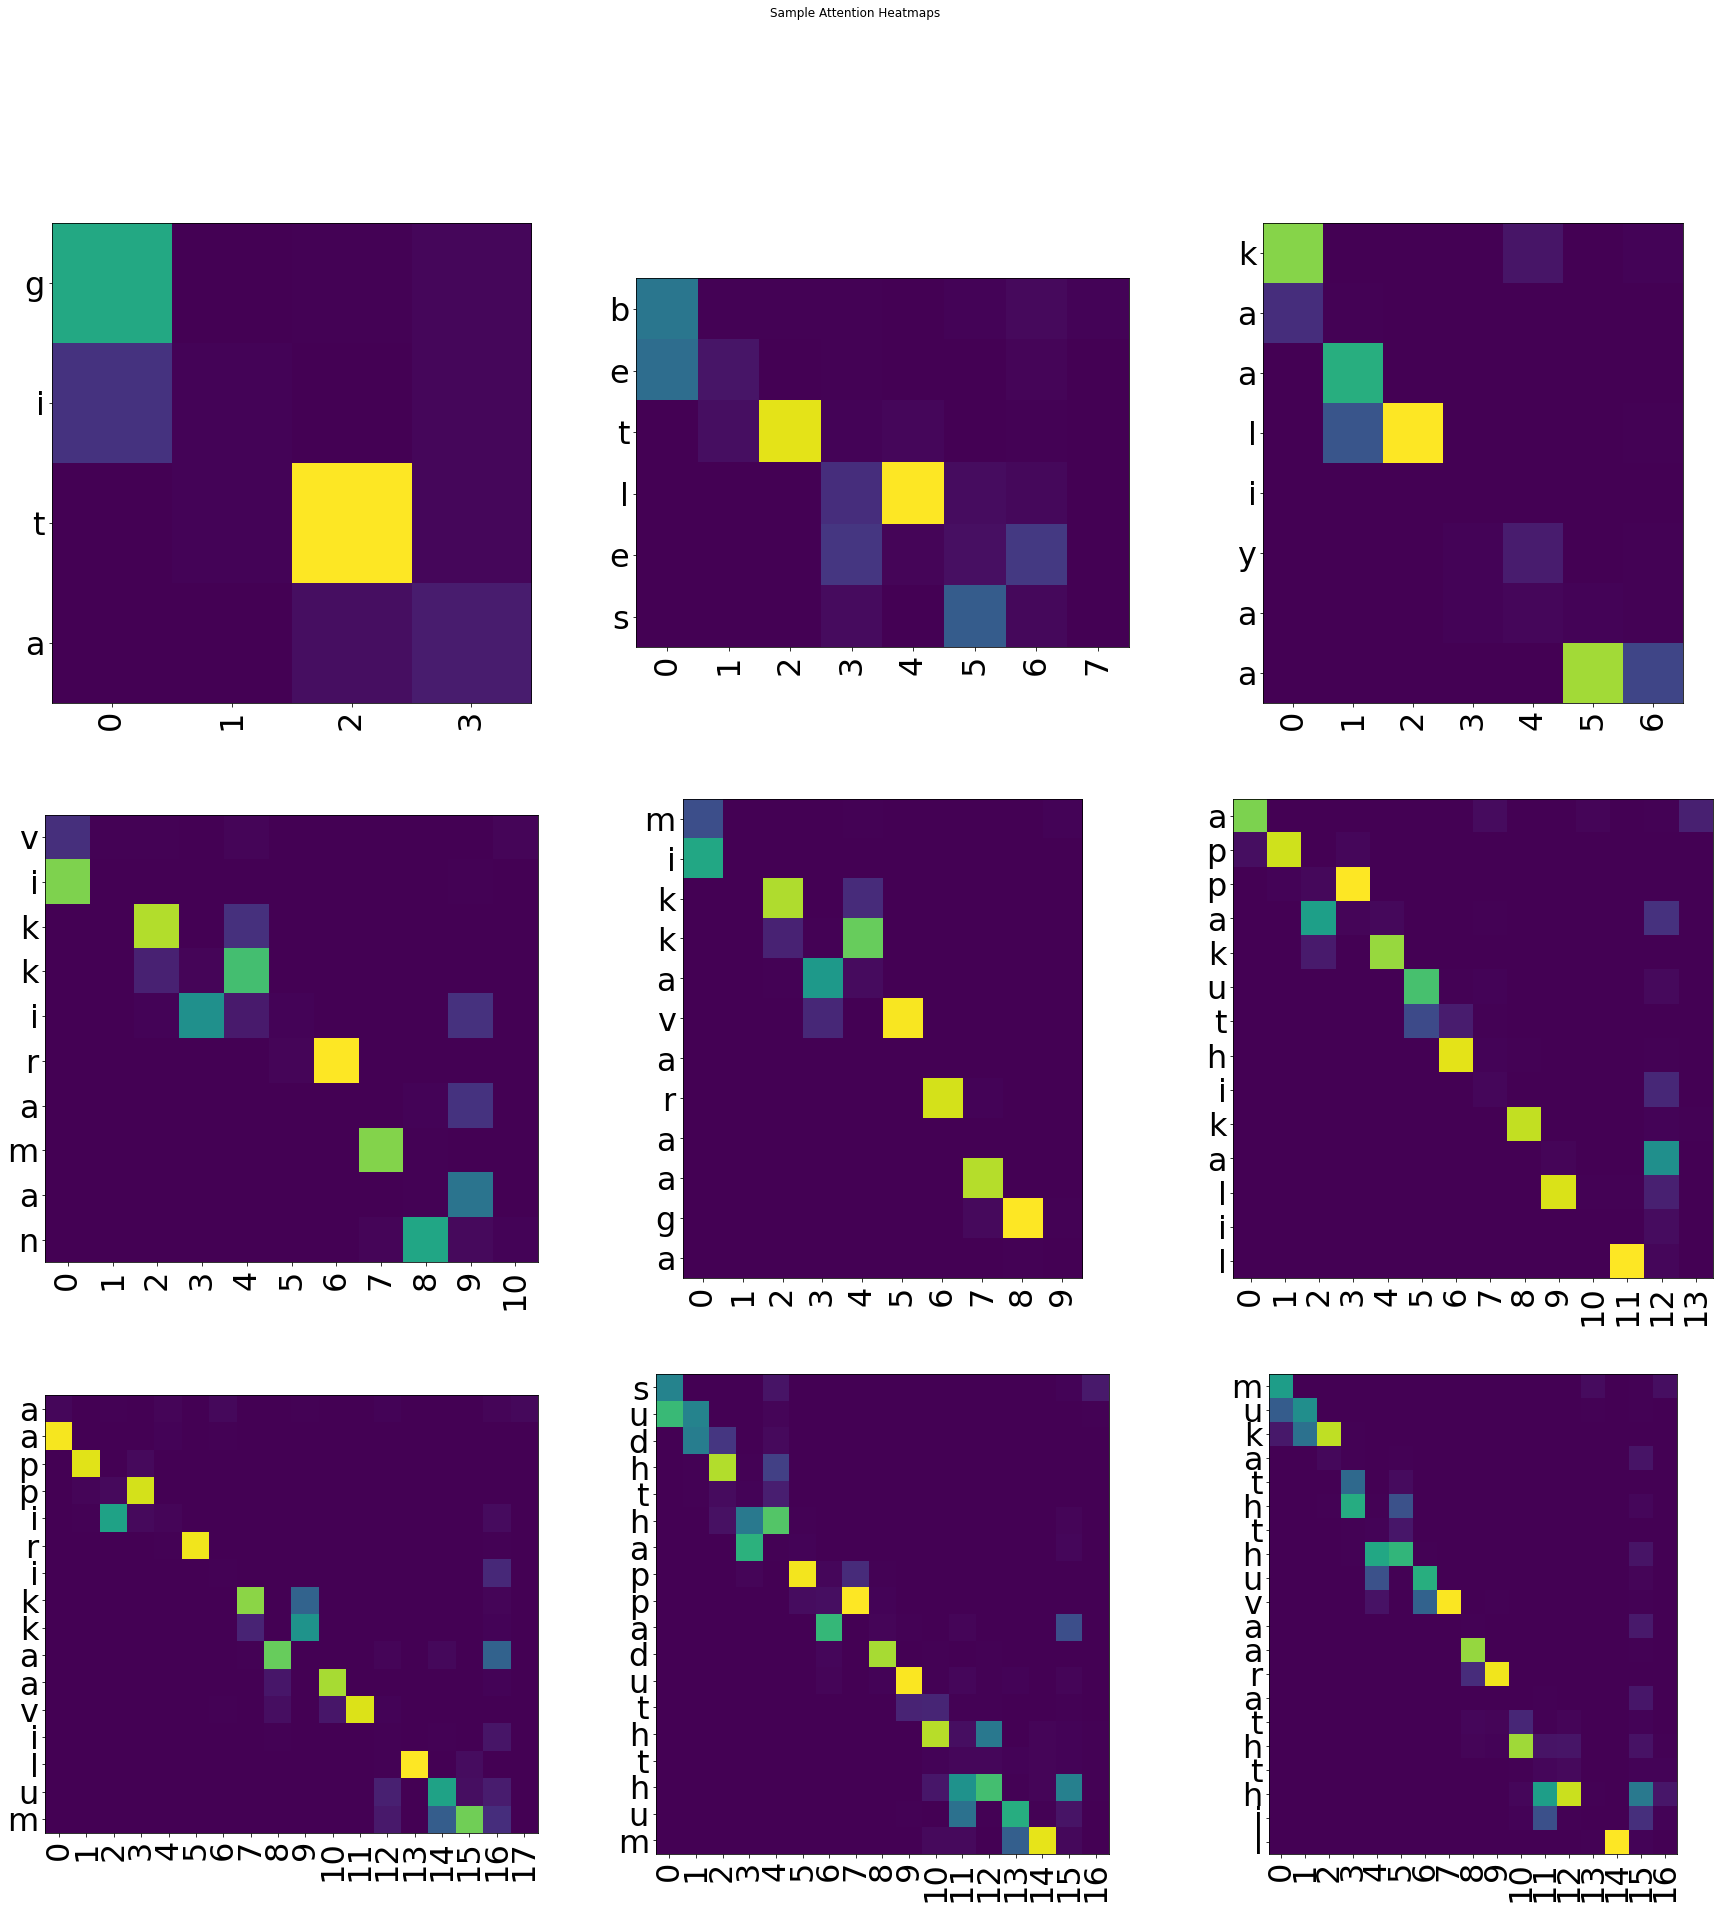

In [111]:
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
axes = axes.flatten()
fig.suptitle('Sample Attention Heatmaps')

for i, (index, row) in enumerate(df_4.iterrows()):
  input_word = row['X']
  output_word = row['true']
  output_word_list = list(output_word)
  weight = all_attn_weights[row['idx']]

  # print(len(weight))
  mats = []
  l = len(input_word)
  output_word_list.append('\n')
  for attn in weight:
      mats.append(attn.reshape(-1)[:l])
      
  attention_mat = np.transpose(np.array(mats))

  ax = axes[i]
  ax.imshow(attention_mat)

  ax.set_xticks(np.arange(attention_mat.shape[1]))
  ax.set_yticks(np.arange(attention_mat.shape[0]))


  ax.set_xticklabels([i for i in range(len(output_word_list))])
  ax.set_yticklabels([inp for inp in input_word])

  ax.tick_params(labelsize=32)
  ax.tick_params(axis='x', labelrotation=90)

wandb.log({"Attention Heatmaps": wandb.Image(fig, caption='Attention Heatmaps')})

In [112]:
df_5 = df_4.copy()
df_5['List Input'] = df_5.apply(lambda x: list(x['X']), axis=1)
df_5['List Output'] = df_5.apply(lambda x: list(x['pred']), axis=1)
df_5.drop(columns=['X', 'true', 'pred', 'match', 'idx'], inplace=True)

In [113]:
print(df_5.head())

wandb.log({'Heatmap Table': wandb.Table(dataframe=df_5)})

   X_len                            List Input                     List Output
0      4                          [g, i, t, a]                    [க, ீ, த, ை]
1      6                    [b, e, t, l, e, s]  [ப, ீ, ட, ், ட, ி, ல, ், ஸ, ்]
2      8              [k, a, a, l, i, y, a, a]              [க, ா, ல, ி, ய, ா]
3     10        [v, i, k, k, i, r, a, m, a, n]  [வ, ி, க, ், க, ி, ர, ம, ன, ்]
4     12  [m, i, k, k, a, v, a, r, a, a, g, a]     [ம, ி, க, ், க, வ, ர, ா, க]
